# Simulation Result Analysor

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
print(matplotlib.matplotlib_fname())
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

sns.set_style("ticks")
font = {
#     "font.family": "SimHei",
    "font.size": 12,
}
sns.set_style(font)
paper_rc = {
    "lines.linewidth": 3,
    "lines.markersize": 10,
}
sns.set_context("paper", font_scale=1.8, rc=paper_rc)
current_palette = sns.color_palette()

pd.set_option("display.max_columns", None)
cmp = sns.color_palette("tab10")
color_list = [cmp[7], cmp[1], cmp[2], cmp[4], cmp[-1]]


policy_dict = {"fifo": "FIFO", "sjf": "SJF", "qssf": "QSSF", "tiresias": "Tiresias", "lucid": "Lucid"}
policy_list = list(policy_dict.values())
policy_list_lower = list(policy_dict.keys())
cluster_list = ["Venus", "Saturn", "Philly"]
experiment_list = ["Venus_Sept", "Saturn_Sept", "Philly"]
# cluster_list = ["Saturn", "Venus", "Philly"]
# experiment_list = ["Saturn_Sept", "Venus_Sept", "Philly"]

save = True
experiment_name = experiment_list[0]
log_dir = f"../log/{experiment_name}"
placer = "consolidate"
cluster = experiment_name.split("_")[0]

jct_avg = pd.read_csv(f"{log_dir}/jct_avg_{placer}.csv", index_col=0)
que_avg = pd.read_csv(f"{log_dir}/que_avg_{placer}.csv", index_col=0)


def process_summary(df):
    all_df = df.loc[["all"]]
    df = df.drop(index="all")
    df.sort_values(by="fifo_consolidate", ascending=False, inplace=True)
    df = df.head(10)
    df = pd.concat([df, all_df])

    if "srtf_consolidate" in df.columns:
        df = df.drop(columns="srtf_consolidate")

    # exchange tiresias and lucid
    cols = [x + f'_{placer}' for x in policy_list_lower]
    # cols[-1], cols[-2] = cols[-2], cols[-1]
    df = df.reindex(columns=cols)
    return df

Duplicate key in file PosixPath('/home/lihe/Software/Anaconda3/envs/lucid/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 271 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


/home/lihe/Software/Anaconda3/envs/lucid/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


## Table 4: Result Summary

In [2]:
jct = pd.DataFrame() # Average JCT
que = pd.DataFrame() # Average Queuing Delay
quetail = pd.DataFrame() # Queuing Delay Quantile

for experiment_name in ["Venus_Sept"]:
    cluster = experiment_name.split('_')[0]
    for policy in policy_list:
        log = pd.read_csv(f'../log/{experiment_name}/all/{policy.lower()}_consolidate_all_log.csv')
        jct.at[policy, cluster] = log['jct'].mean()
        que.at[policy, cluster] = log['queue'].mean()
        quetail.at[policy, cluster] = log['queue'].quantile(q=0.999)

print("平均作业完成时间")
print(jct.astype(int))
print("\n平均排队延迟")
print(que.astype(int))
print("\n第99.9百分位数排队延迟")
print(quetail.astype(int))

jct = pd.concat([jct, que, quetail])
jct = jct.astype(int)
jct.to_csv('result_summary.csv')

平均作业完成时间
          Venus
FIFO      65720
SJF       21095
QSSF      15548
Tiresias  14700
Lucid     16080

平均排队延迟
          Venus
FIFO      53951
SJF        9325
QSSF       3779
Tiresias   2915
Lucid      4369

第99.9百分位数排队延迟
           Venus
FIFO      587040
SJF       322076
QSSF      214309
Tiresias  195846
Lucid     221435


## Table 5: Result Summary of Different Scales of Workloads

In [6]:
jct = pd.DataFrame()  # Average JCT
que = pd.DataFrame()  # Average Queuing Delay

for experiment_name in ["Venus_Sept"]:
    cluster = experiment_name.split("_")[0]
    for policy in ["fifo", "tiresias", "lucid"]:
        log = pd.read_csv(f"../log/{experiment_name}/all/{policy.lower()}_consolidate_all_log.csv")
        jct.at[policy, f"{cluster}(Large)"] = log[log["gpu_num"] > 8]["jct"].mean()
        jct.at[policy, f"{cluster}(Small)"] = log[log["gpu_num"] <= 8]["jct"].mean()
        que.at[policy, f"{cluster}(Large)"] = log[log["gpu_num"] > 8]["queue"].mean()
        que.at[policy, f"{cluster}(Small)"] = log[log["gpu_num"] <= 8]["queue"].mean()

print("平均作业完成时间")
print(jct.astype(int))
print("\n平均排队延迟")
print(que.astype(int))

平均作业完成时间
          Venus(Large)  Venus(Small)
fifo             35566         69158
tiresias         21781         13892
lucid            27462         14782

平均排队延迟
          Venus(Large)  Venus(Small)
fifo             22117         57580
tiresias          8294          2302
lucid            14012          3269


## Plot Result 8: JCT

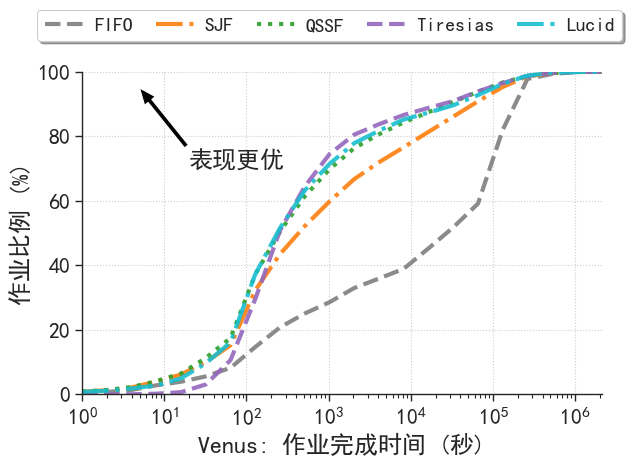

In [4]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(6, 4))
axs = [axs]

experiment_list = ["Venus_Sept"]
placer = "consolidate"
cluster_list = ["Venus"]
linestyles = ["--", "-.", ":", "--", "-.", "-"]

for e in range(0, len(experiment_list)):
    for k in range(0, len(policy_list_lower)):
        job_ratio = []
        time = [2**i for i in range(0, 22)]

        log_dir = f"../log/{experiment_list[e]}/all"

        log = pd.read_csv(f"{log_dir}/{policy_list_lower[k]}_{placer}_all_log.csv")

        for t in time:
            job_ratio.append(len(log[log["jct"] <= t]) / len(log) * 100)

        axs[e].plot(time, job_ratio, linestyles[k], alpha=0.9, label=policy_list[k], color=color_list[k])

marks = {0: "a", 1: "b", 2: "c"}
for e in range(1):
    axs[e].set_xscale("log")
    axs[e].set_xlabel(f"{cluster_list[e]}: 作业完成时间 (秒)")
    axs[e].set_ylabel(f"作业比例 (%)")
    axs[e].set_xlim(1, time[-1])
    axs[e].set_ylim(0, 100)
    axs[e].grid(linestyle=":")

axs[0].annotate("表现更优", xy=(5, 95), xytext=(20, 70), arrowprops=dict(facecolor="black", width=3.5, headwidth=10))


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=6,
    bbox_to_anchor=(0.54, 1.15),
    fancybox=True,
    shadow=True,
    fontsize=14,
    handletextpad=0.5,
    columnspacing=1.2,
)
sns.despine()

save = True
if save:
    fig.savefig(f"result_cdf_jct.pdf", bbox_inches="tight")


## Plot Result 9: Queue Time in each VC

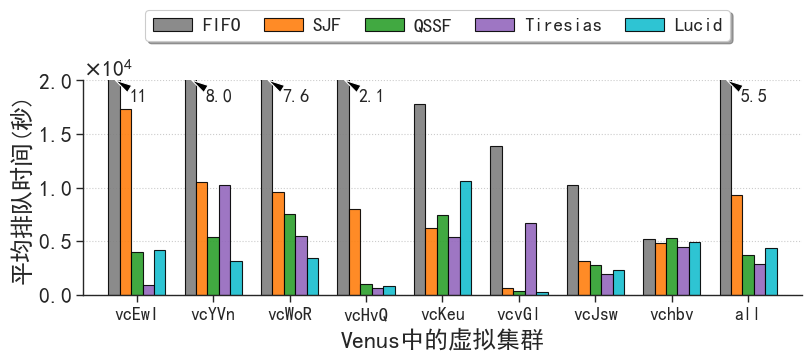

In [5]:
from matplotlib.gridspec import GridSpec

jct_avg = [None]*3
que_avg = [None]*3
cluster = [None]*3
cmp = sns.color_palette("tab10")
def read_file(experiment_name):
    log_dir = f"../log/{experiment_name}"
    placer = "consolidate"
    cluster = experiment_name.split("_")[0]

    jct_avg = pd.read_csv(f"{log_dir}/jct_avg_{placer}.csv", index_col=0)
    que_avg = pd.read_csv(f"{log_dir}/que_avg_{placer}.csv", index_col=0)
    jct_avg = process_summary(jct_avg)
    que_avg = process_summary(que_avg)
    return jct_avg, que_avg, cluster

jct_avg[0], que_avg[0], cluster[0] = read_file(experiment_list[0])
que_avg[0].drop(['vcLTP', 'vchA3'], inplace=True)

grid_params=dict(width_ratios=[6, 6, 1])
fig, axs = plt.subplots(ncols=1, nrows=1, constrained_layout=True, figsize=(8, 3))
axs = [axs]

width = 0.15
x = np.arange(1, len(que_avg[0]) + 1)
off = width * len(que_avg[0].columns) * 2
labels = []
for c in que_avg[0].columns:
    labels.append(c.split("_")[0])

col_num = len(que_avg[0].columns)
for i in range(col_num):
    offset = i - col_num // 2
    p1 = axs[0].bar(
        x + offset * width,
        que_avg[0].iloc[:, i],
        width,
        alpha=0.9,
        linewidth=0.8,
        edgecolor="k",
        label=policy_dict[labels[i]],
        color=color_list[i]
    )

ylabel = f"平均排队时间(秒)"
axs[0].set_xlabel(f"{cluster[0]}中的虚拟集群")
axs[0].set_ylabel(ylabel)
# axs[0].set_yscale('log')
axs[0].set_xticks(x)
axs[0].set_xlim(0.3, 9.7)
axs[0].set_ylim(0, 20000)
axs[0].set_xticklabels(que_avg[0].index.values, fontsize=13)
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(-6, 2), useMathText=True)
axs[0].grid(axis="y", linestyle=":")
axs[0].annotate("11", xy=(0.72, 19999), xytext = (0.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("8.0", xy=(1.72, 19999), xytext = (1.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("7.6", xy=(2.72, 19999), xytext = (2.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("2.1", xy=(3.72, 19999), xytext = (3.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
axs[0].annotate("5.5", xy=(8.72, 19999), xytext = (8.9, 18000), arrowprops=dict(facecolor='black', width=2, headwidth=6), fontsize=13)
sns.despine()


handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=6,
    bbox_to_anchor=(0.54, 1.18),
    fancybox=True,
    shadow=True,
    fontsize=14,
    handletextpad=0.5,
    columnspacing=1.2
)
save = True
if save:
    fig.savefig(f"result_bar_queue.pdf", bbox_inches="tight")
